In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.insert(0,"../")
#print(sys.path)
from disk_model import *
import dill as pickle

In [2]:
disk_opacity = pickle.load(open('../data/opacity_tables/disk_opacity.pkl','rb'))
disk_opacity_lam = pickle.load(open('../data/opacity_tables/disk_opacity_lam.pkl','rb'))
disk_property = pickle.load(open('../data/opacity_tables/disk_property.pkl','rb'))

In [3]:
def get_alpha_and_afrag(D, vfrag=100, vfrag_snow=None):
    R = D.R[1:]
    Sigma = D.Sigma
    MR = D.MR
    Omega = np.sqrt(G*MR/R**3)
    Q = D.Q10 * (R/10/au)**D.Qs
    kappa = Omega*np.sqrt(1+2*pi*R**2*Sigma/MR)
    cs = Q*pi*G*Sigma/kappa
    Mdot = D.Mdot
    T = D.T_mid
    alpha = Mdot/(3*np.pi*Sigma*cs**2/Omega)
    St = vfrag**2/(9/2*alpha*cs**2)
    #St = 1/(vfrag**2/(3/2*alpha*cs**2) - 1)-1
    rhos = 1.68 + (2.11-1.68)*(T>150) + (1.68-2.11)*(T>425) + (1.5-1.68)*(T>680)
    afrag = St/(rhos/Sigma*pi/2)
    return alpha, afrag

In [4]:
def plot_disk_properties(D, ax, plot_a_frag=False):
    r = D.R[1:]
    r = r/au
    I = (D.T_mid>1)*(r>1) # screen out regions after truncation and the innermost 5au
    alpha, afrag = get_alpha_and_afrag(D)
    I = I * (alpha<1)
    plt.sca(ax[0])
    plt.plot(r[I],D.Sigma[I])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('r [au]')
    plt.ylabel('Sigma [g cm-2]')
    plt.sca(ax[1])
    plt.plot(r[I],D.T_mid[I])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('r [au]')
    plt.ylabel('T_mid [K]')
    plt.sca(ax[2])
    plt.plot(r[I],alpha[I])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('r [au]')
    plt.ylabel('alpha_GI')
    plt.sca(ax[3])
    plt.plot(r[I],(D.amax10*(r/10)**D.amaxs)[I])
    plt.plot(r[I],afrag[I],'k--')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('r [au]')
    plt.ylabel('a_max [cm] (a_frag: dashed)')
    plt.sca(ax[4])
    plt.plot(r[I],D.tau_r_mid[I])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('r [au]')
    plt.ylabel('midplane tau_R')

In [5]:
def save_disk_properties(D, fname):
    D.generate_disk_profile()
    alpha, afrag = get_alpha_and_afrag(D)
    r = D.R[1:]
    r = r/au
    I = (D.T_mid>1)*(r>1)*(alpha<1) # we leave T_mid ~ 0 in the truncated region
    header = "r [au]                 Sigma [g cm-2]           T_mid [K]                alpha                    a_max [cm]               tau_mid (Planck)         tau_mid (Rosseland)"
    np.savetxt(fname,np.transpose(
        [r[I], D.Sigma[I], D.T_mid[I], alpha[I], (D.amax10*(r/10)**D.amaxs)[I], D.tau_r_mid[I], D.tau_p_mid[I]]), header=header)
    return

In [6]:
D = DiskModel(disk_opacity, disk_opacity_lam, disk_property)

In [7]:
# TMC1A
D.M = 0.81*Msun
D.Mdot = 2e-6*Msun/yr
D.Rd = 199*au
D.Q10 = 1.1 # Q at 10au
D.Qs = 0. # radial slope of Q
D.amax10 = 0.02 # amax at 10au
D.amaxs = -2.46 # radial slope of amax
D.q = 3.5 # slope of grain size distribution
D.generate_disk_profile()

save_disk_properties(D, "tmc1a.txt")

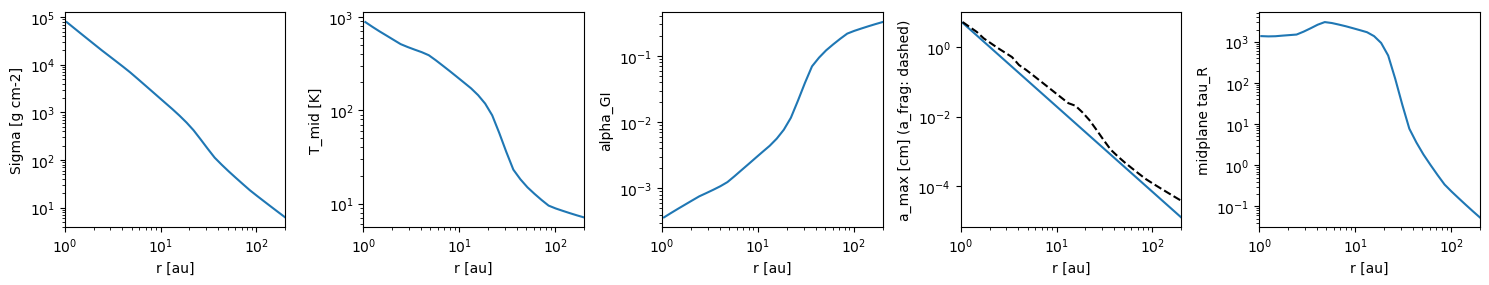

In [8]:
fig, ax = plt.subplots(1,5,figsize=(15,3))
for ax1 in ax:
    ax1.set_xlim(1,200)
plot_disk_properties(D, ax, plot_a_frag=True)
plt.tight_layout()

In [9]:
def estimate_grain_size(D,n_itr=5):
    for i in range(n_itr):
        D.generate_disk_profile()
        alpha, afrag = get_alpha_and_afrag(D)
        # fit afrag profile at r>5au to a power law
        r = D.R[1:]
        r = r/au
        I = (D.T_mid>1)*(r>5)
        p=np.polyfit(np.log(r[I]/10),np.log(afrag[I]),1)
        D.amax10=np.exp(p[1])
        D.amaxs=p[0]
    D.generate_disk_profile()
    return D

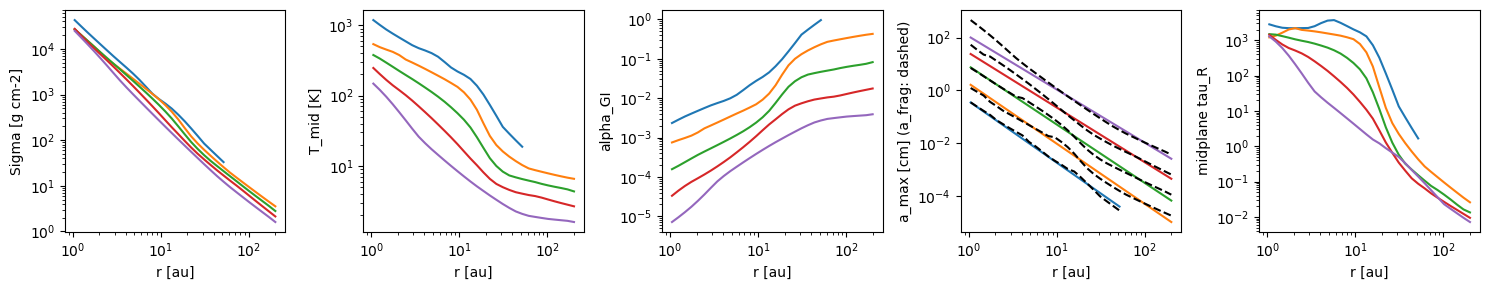

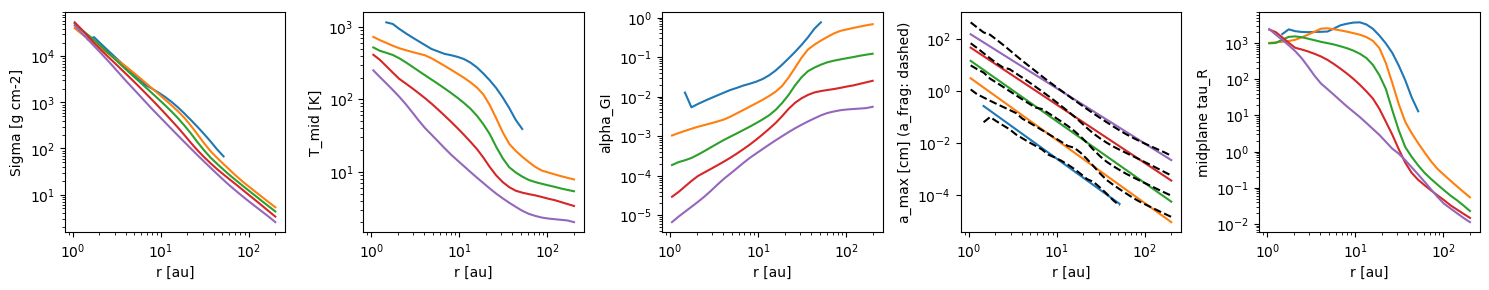

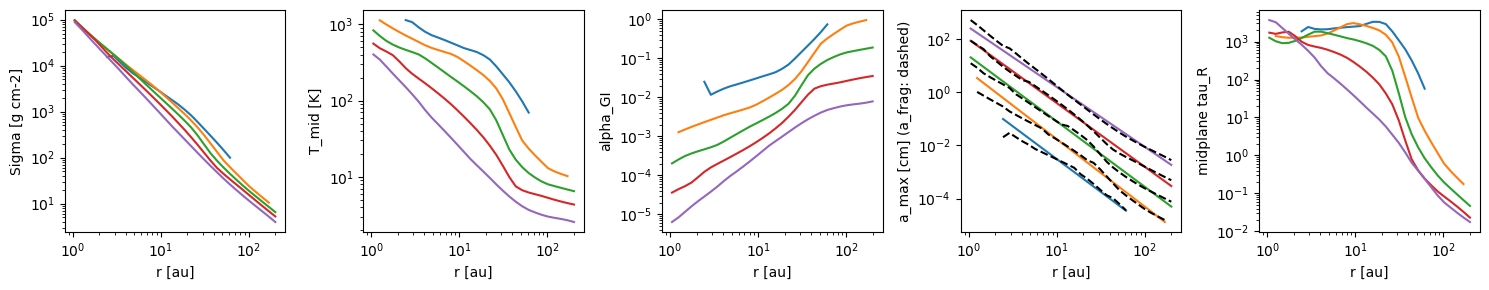

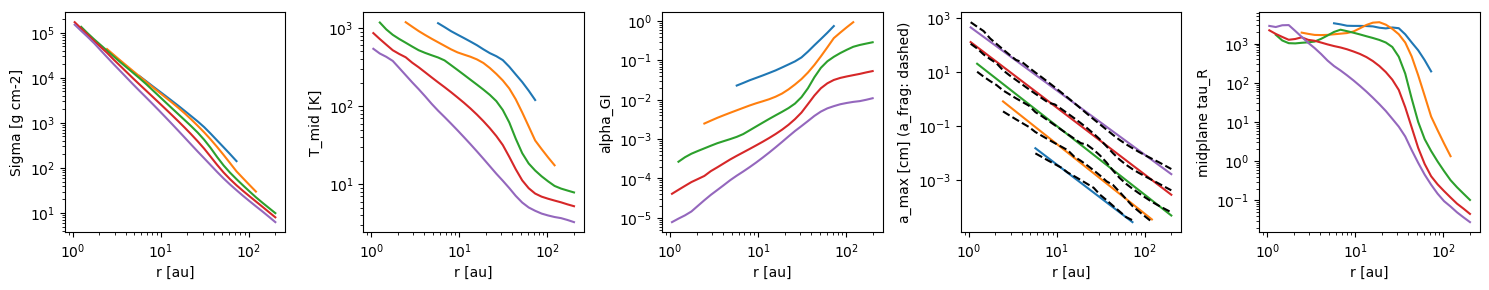

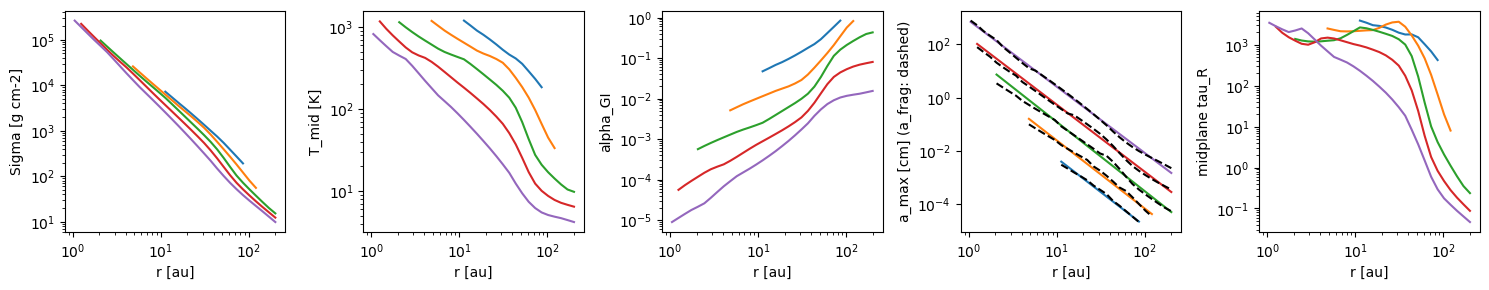

In [10]:
# other sample disks:
# sample disk
D.M = 1*Msun # will be updated
D.Mdot = 1e-6*Msun/yr # will be updated
D.Rd = 200*au
D.Q10 = 1.1
D.Qs = 0.
D.amax10 = 0.01 # will be updated
D.amaxs = -2 # will be updated
D.q = 3.5
for M in [0.25,0.5,1,2,4]:
    fig, ax = plt.subplots(1,5,figsize=(15,3))
    for Mdot_over_M in [1e-4,1e-5,1e-6,1e-7,1e-8]:
        fname = 'M{:.2f}_tacc{:.0e}.txt'.format(M, 1/Mdot_over_M)
        D.M = M*Msun
        D.Mdot = M*Mdot_over_M*Msun/yr
        D = estimate_grain_size(D)
        plot_disk_properties(D, ax)
        save_disk_properties(D, fname)
    plt.tight_layout()